# Problem Statement Reminder
Iowa Real Estate Investors Association (IaREIA) has reached out to get a strong predictive model, ready to base their investment plans for Ames, Iowa region. 

Model Evaluation Focuses on:
- R2 value
- RMSE
- Max Error


___

Imports

In [65]:
# general data and data viz imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

# importing relevant models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.linear_model import Ridge 
from sklearn.linear_model import RidgeCV 
from sklearn.preprocessing import StandardScaler

# importing metrics 
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error
from sklearn.model_selection import train_test_split
from scipy import stats 

#importing helper functions
from helper_functions import metric_reg
from helper_functions import turkey_outliers
from helper_functions import null_reminders 

# adjusting display restrictions 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000
# setting preference to remove scientific notation 
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline



___
Outside Research:<br><br>
Based on the hedonic pricing system and binned the largest absolute coefficients for comparision below:



| Original Characteristic | First Attempt - Feature Proxy (R2 value 0.80)| Lasso Attempt (R2 value 0.91)|
| --- | --- | --- |
| Property Size     | Lot Area | gr_liv_area + total_bsmt_sf|
|Location Desireability    | Overall Quality |overall_qual|
|Amenities Proximity  |Cond 1 / Cond 2| Cond 2|
|Number of Rooms  |Bedrooms|bedroom_abvgr|
| Number of baths  |Full Bath / Half Bath|full_bath|
|Age  |Year Built/Original Contstruction Date|year_built + year_remod/add|
|Condition of the house  |condition_1 + condition_2 |condition_2_PosA + condition_2_PosN + condition_2_Norm + condition_2_RRNn + condition_2_RRAn|
|Construction Materials  |Remodel|roof_matl_WdShngl + roof_matl_WdShngl|

---

In [89]:
# importing MLR models from before feature engineering for comparison
pre_feat_EGR = pd.read_csv('../data/MLR_pre_Feat_engineering.csv')
# importing lasso coefficients for discussion
lasso_complete = pd.read_csv('../data/lasso_coefficient_features.csv')

In [90]:
# import a seperate test to determine the validity of my final model on brand new data!
secondary_test = pd.read_csv('../data/test.csv')

post_lasso_OG = pd.read_csv('../data/scrubbed_post_lasso.csv')
post_lasso_OG2 = pd.read_csv('../data/scrubbed_post_lasso.csv')
post_lasso_final = pd.read_csv('../data/scrubbed_post_lasso.csv')

orignal_shape = post_lasso_OG.shape
post_lasso_OG.head()

,id,gr_liv_area,overall_qual,year_built,bsmtfin_sf_1,neighborhood_StoneBr,neighborhood_NridgHt,exter_qual_Ex,total_bsmt_sf,kitchen_qual_Ex,neighborhood_NoRidge,lot_area,bsmt_qual_Ex,bsmt_exposure_Gd,overall_cond,bldg_type_1Fam,neighborhood_GrnHill,screen_porch,fireplaces,garage_yr_blt_2009.0,garage_area,full_bath,neighborhood_Crawfor,roof_matl_WdShngl,heating_qc_Ex,neighborhood_Somerst,bsmt_full_bath,year_remod/add,exterior_1st_BrkFace,mas_vnr_area,land_contour_HLS,garage_cars,garage_qual_Gd,functional_Typ,condition_1_PosN,condition_1_Norm,garage_yr_blt_2006.0,foundation_PConc,bsmt_exposure_Av,bsmtfin_type_1_GLQ,roof_style_Mansard,neighborhood_Edwards,kitchen_qual_TA,ms_subclass,exter_qual_TA,roof_matl_ClyTile,saleprice
0,109,1479,6,1976,533.00,0,0,0,725.00,0,0,13517,0,0,8,1,0,0,0,0,475.00,2,0,0,1,0,0.00,2005,0,289.00,0,2.00,0,1,0,0,0,0,0,1,0,0,0,60,0,0,130500
1,544,2122,7,1996,637.00,0,0,0,913.00,0,0,11492,0,0,5,1,0,0,1,0,559.00,2,0,0,1,0,1.00,1997,0,132.00,0,2.00,0,1,0,1,0,1,0,1,0,0,0,60,0,0,220000
2,153,1057,5,1953,731.00,0,0,0,"1,057.00",0,0,7922,0,0,7,1,0,0,0,0,246.00,1,0,0,0,0,1.00,2007,0,0.00,0,1.00,0,1,0,1,0,0,0,1,0,0,0,20,1,0,109000
3,318,1444,5,2006,0.00,0,0,0,384.00,0,0,9802,0,0,5,1,0,0,0,0,400.00,2,0,0,0,0,0.00,2007,0,0.00,0,2.00,0,1,0,1,0,1,0,0,0,0,1,60,1,0,174000
4,255,1445,6,1900,0.00,0,0,0,676.00,0,0,14235,0,0,8,1,0,0,0,0,484.00,2,0,0,0,0,0.00,1993,0,0.00,0,2.00,0,1,0,1,0,1,0,0,0,0,1,50,1,0,138500


---

In [91]:
post_lasso_OG['saleprice'].describe()

count     2,051.00
mean    181,469.70
std      79,258.66
min      12,789.00
25%     129,825.00
50%     162,500.00
75%     214,000.00
max     611,657.00
Name: saleprice, dtype: float64

---

# Checking Colinearity on Features

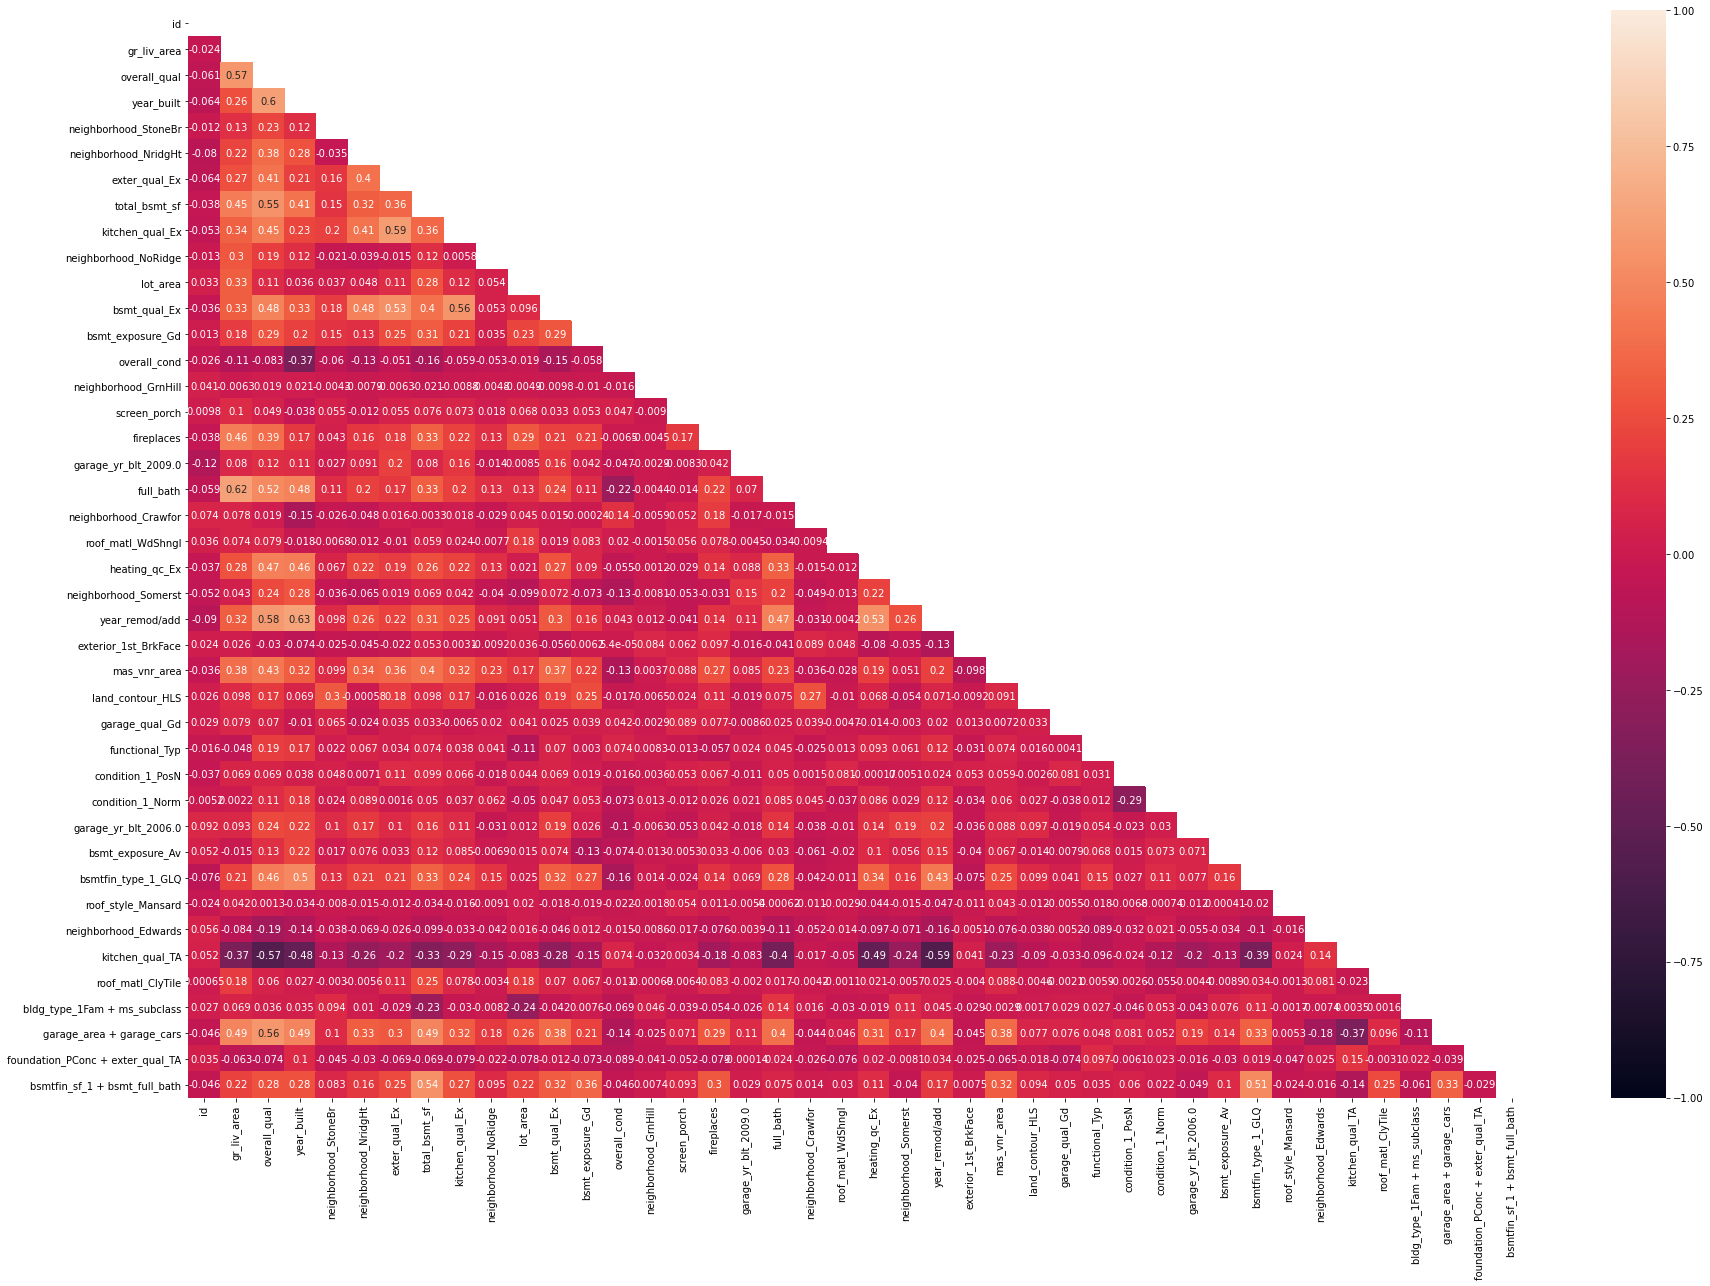

In [15]:
X = post_lasso_OG.drop(columns=['saleprice'])
corr_x = X.corr()
plt.figure(figsize=(30,20))
corr = X.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_x,annot=True,vmin=-1,vmax=1,mask = mask);
# Saving the Seaborn Figure(code reference: https://www.marsja.se/how-to-save-a-seaborn-plot-as-a-file-e-g-png-pdf-eps-tiff/)
plt.savefig('../viz/heatmaps/post_lasso_mlr_with_FE.pdf', dpi=300,transparent=True) # high ress=

There are a clear amount of colinearity between many of my features within this strong predictive model. So to attempt to minimize the stronger correlations several feature interactions will be made to combine these features into one and then drop their original columns, afterwards if improvent in the model. This will hopefully reduce some of the redundancy within the model.

# Multiple Interactions made for top corrlation relationships (additive and multiplication method)
| Correlation Values | Features Proxys from Lasso Selection |
| --- | --- | 
| 0.80+ |   bldg_type_1Fam / ms_subclass  &  garage_area /garage_cars  |
| 0.65+ | foundation_PConc / exter_qual_TA   &      bsmtfin_sf_1 / bsmt_full_bath |

Understandbly it is a very large heatmap so from this the most significant correlation relationships between the features will be combined and they will be put in place of the original features in the table above. 

 # Feature Engineering 

Combining features with over 0.6 correlation values

In [92]:
post_lasso_OG['bldg_type_1Fam + ms_subclass'] = post_lasso_OG['bldg_type_1Fam']*post_lasso_OG['ms_subclass']
post_lasso_OG = post_lasso_OG.drop(columns = ['bldg_type_1Fam','ms_subclass']) # attempt to minimize even more colinearity 
post_lasso_OG['bldg_type_1Fam + ms_subclass'].head(2)

0    60
1    60
Name: bldg_type_1Fam + ms_subclass, dtype: int64

In [93]:
post_lasso_OG['garage_area + garage_cars'] = post_lasso_OG['garage_area']*post_lasso_OG['garage_cars']
post_lasso_OG.drop(columns = ['garage_area','garage_cars'],inplace = True) # attempt to minimize even more colinearity 
post_lasso_OG['garage_area + garage_cars'].head(2)

0     950.00
1   1,118.00
Name: garage_area + garage_cars, dtype: float64

In [94]:
post_lasso_OG['foundation_PConc + exter_qual_TA'] = post_lasso_OG['foundation_PConc']*post_lasso_OG['exter_qual_TA']
post_lasso_OG = post_lasso_OG.drop(columns = ['foundation_PConc','exter_qual_TA']) # attempt to minimize even more colinearity 
post_lasso_OG['foundation_PConc + exter_qual_TA'].head(2)

0    0
1    0
Name: foundation_PConc + exter_qual_TA, dtype: int64

In [95]:
post_lasso_OG['bsmtfin_sf_1 + bsmt_full_bath'] = post_lasso_OG['bsmtfin_sf_1']*post_lasso_OG['bsmt_full_bath']
post_lasso_OG = post_lasso_OG.drop(columns = ['bsmtfin_sf_1','bsmt_full_bath']) # attempt to minimize even more colinearity 
post_lasso_OG['bsmtfin_sf_1 + bsmt_full_bath'].head(2)

0     0.00
1   637.00
Name: bsmtfin_sf_1 + bsmt_full_bath, dtype: float64

In [96]:
print('original shape: ',orignal_shape)
print('after additive features: ',post_lasso_OG.shape)

original shape:  (2051, 47)
after additive features:  (2051, 43)


--- 
Rerun linear model compare to previous model iterations in pre_feat_EGR data frame


In [97]:
pre_feat_EGR.head()

,R2_train,R2test,R2_adj_train,R2_test_adj,mse_train,mse_test,RMSE_train,RMSE_test,max_error_train,max_error_test
0,0.71,0.80,0.71,0.79,"1,847,872,276.24","1,203,571,128.51","42,986.88","34,692.52","34,692.52","597,274.19"
1,0.80,0.81,0.80,0.80,"1,229,946,510.34","1,297,984,549.52","35,070.59","36,027.55","36,027.55","231,705.77"
2,0.92,0.91,0.92,0.90,"513,400,123.47","523,659,785.04","22,658.33","22,883.61","22,883.61","230,770.78"
3,0.91,0.91,0.91,0.91,"570,596,921.72","512,874,818.65","23,887.17","22,646.74","22,646.74","395,436.15"


In [87]:
lr4 = LinearRegression()
#dummified_OG = dummified_OG[OG_features_of_interest] # same features from lasso model in MLR model
X = post_lasso_OG.drop(columns = ['saleprice']) 
y = post_lasso_OG['saleprice']

# test size spliter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size=0.3)
lr4.fit(X_train,y_train)
iter4 = metric_reg(lr4,X_train,y_train,X_test,y_test)

# here I am creatin arunning data frame to compare my metrics across my model alterations for quick access! #guiding code: https://www.stackvidhya.com/add-row-to-dataframe/#:~:text=You%20can%20add%20rows%20to,append()
MLR_w_FE= pre_feat_EGR.append(iter4, ignore_index = True)
MLR_w_FE.head()


,R2_train,R2test,R2_adj_train,R2_test_adj,mse_train,mse_test,RMSE_train,RMSE_test,max_error_train,max_error_test
0,0.71,0.80,0.71,0.79,"1,847,872,276.24","1,203,571,128.51","42,986.88","34,692.52","34,692.52","597,274.19"
1,0.80,0.81,0.80,0.80,"1,229,946,510.34","1,297,984,549.52","35,070.59","36,027.55","36,027.55","231,705.77"
2,0.92,0.91,0.92,0.90,"513,400,123.47","523,659,785.04","22,658.33","22,883.61","22,883.61","230,770.78"
3,0.91,0.91,0.91,0.91,"570,596,921.72","512,874,818.65","23,887.17","22,646.74","22,646.74","395,436.15"
4,0.91,0.91,0.90,0.90,"602,119,041.84","564,404,196.65","24,538.11","23,757.19","23,757.19","412,620.88"


# taslk here


Second Approach with Additive Features (not dropping columns)

In [98]:
# adding same features as above but not droppping columns
post_lasso_OG = pd.read_csv('../data/scrubbed_post_lasso.csv')
print('prior to addtion of additive features: ',post_lasso_OG2.shape)
post_lasso_OG2['bldg_type_1Fam + ms_subclass'] = post_lasso_OG2['bldg_type_1Fam'] + post_lasso_OG2['ms_subclass']
post_lasso_OG = post_lasso_OG.drop(columns = ['bldg_type_1Fam','ms_subclass']) # attempt to minimize even more colinearity 
post_lasso_OG2['garage_area + garage_cars'] = post_lasso_OG2['garage_area'] + post_lasso_OG2['garage_cars']
post_lasso_OG.drop(columns = ['garage_area','garage_cars'],inplace = True) # attempt to minimize even more colinearity 
post_lasso_OG2['foundation_PConc + exter_qual_TA'] = post_lasso_OG2['foundation_PConc'] + post_lasso_OG2['exter_qual_TA']
post_lasso_OG = post_lasso_OG.drop(columns = ['foundation_PConc','exter_qual_TA']) # attempt to minimize even more colinearity 
post_lasso_OG2['bsmtfin_sf_1 + bsmt_full_bath'] = post_lasso_OG2['bsmtfin_sf_1'] + post_lasso_OG2['bsmt_full_bath']
post_lasso_OG = post_lasso_OG.drop(columns = ['bsmtfin_sf_1','bsmt_full_bath']) # attempt to minimize even more colinearity 

print('post additive featus: ',post_lasso_OG2.shape)


prior to addtion of additive features:  (2051, 47)
post additive featus:  (2051, 51)


In [99]:
# running model again without dropped additiev features 
# slight adjustment from first MLR Lasso informed model
lr5 = LinearRegression()
#dummified_OG = dummified_OG[OG_features_of_interest] # same features from lasso model in MLR model
X = post_lasso_OG.drop(columns = ['saleprice']) 
y = post_lasso_OG['saleprice']

# test size spliter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size=0.3)
lr5.fit(X_train,y_train)
iter5 = metric_reg(lr5,X_train,y_train,X_test,y_test)

# here I am creatin arunning data frame to compare my metrics across my model alterations for quick access! #guiding code: https://www.stackvidhya.com/add-row-to-dataframe/#:~:text=You%20can%20add%20rows%20to,append()
MLR_w_FE= MLR_w_FE.append(iter5, ignore_index = True)
MLR_w_FE.head()

,R2_train,R2test,R2_adj_train,R2_test_adj,mse_train,mse_test,RMSE_train,RMSE_test,max_error_train,max_error_test
0,0.71,0.80,0.71,0.79,"1,847,872,276.24","1,203,571,128.51","42,986.88","34,692.52","34,692.52","597,274.19"
1,0.80,0.81,0.80,0.80,"1,229,946,510.34","1,297,984,549.52","35,070.59","36,027.55","36,027.55","231,705.77"
2,0.92,0.91,0.92,0.90,"513,400,123.47","523,659,785.04","22,658.33","22,883.61","22,883.61","230,770.78"
3,0.91,0.91,0.91,0.91,"570,596,921.72","512,874,818.65","23,887.17","22,646.74","22,646.74","395,436.15"
4,0.91,0.91,0.90,0.90,"602,119,041.84","564,404,196.65","24,538.11","23,757.19","23,757.19","412,620.88"


With both approaches clearly there are still increases in the error andthe lr3 model(index value 2) is still the best performing model. This is because although they all similary have a similar R2 value the errors are minimized with the lasso informed MLR model, which coincides with the purpose of the lasso models purpose, return the model that minimizes the amount of error. 



Reverting back to the original model before feature engineering

In [16]:
# referencing the model from the previous eda notebook
lr3 = LinearRegression()
#dummified_OG = dummified_OG[OG_features_of_interest] # same features from lasso model in MLR model
X = post_lasso_final.drop(columns = ['saleprice']) 
y = post_lasso_final['saleprice']

# test size spliter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size=0.3)
lr3.fit(X_train,y_train)
#saving this final model coefficients
final_model =pd.Series(lr3.coef_, index = X.columns)

iter5 = metric_reg(lr3,X_train,y_train,X_test,y_test)
iter5

,R2_train,R2test,R2_adj_train,R2_test_adj,mse_train,mse_test,RMSE_train,RMSE_test,max_error_train,max_error_test
0,0.91,0.91,0.91,0.91,"570,596,921.72","512,874,818.65","23,887.17","22,646.74","22,646.74","395,436.15"


# TO DO  
- defend their choice of production model relevant to the data at hand and the problem?
- explain how the model works and evaluate its performance successes/downfalls?


---
Third Kaggle Submission

In [17]:
secondary_test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.00,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.00,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,"1,910.00",Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.00,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,"1,977.00",Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.00,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.00,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,"2,006.00",RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.00,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,"1,935.00",Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.00,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,"1,963.00",RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [18]:
# running model on secondary test data to determine performance on brand new data
# will dummify test features to test my model post lasso 

dummify2T = secondary_test
print(dummify2T.shape)
dummified_2T = pd.get_dummies(data=dummify2T,drop_first=True) ############# EXPLAIN THAT I SHOULD HAVE NOT DROPPPED! NOMINAL VARS
dummified_2T.head() 
print(dummified_2T.shape)
dummified_2T.head(2)


set(X.columns.tolist()) - set(dummified_2T.columns.tolist()) #columns not matched in my test df

(878, 80)
(878, 230)


{'bldg_type_1Fam',
 'bsmt_exposure_Av',
 'bsmt_qual_Ex',
 'exter_qual_Ex',
 'garage_yr_blt_2006.0',
 'garage_yr_blt_2009.0',
 'heating_qc_Ex',
 'kitchen_qual_Ex',
 'neighborhood_GrnHill',
 'roof_matl_ClyTile'}

In [19]:
dummified_2T = dummified_2T.reindex(columns=X.columns.tolist()).fillna(0)
dummified_2T.head(2)

,id,gr_liv_area,overall_qual,year_built,bsmtfin_sf_1,neighborhood_StoneBr,neighborhood_NridgHt,exter_qual_Ex,total_bsmt_sf,kitchen_qual_Ex,neighborhood_NoRidge,lot_area,bsmt_qual_Ex,bsmt_exposure_Gd,overall_cond,bldg_type_1Fam,neighborhood_GrnHill,screen_porch,fireplaces,garage_yr_blt_2009.0,garage_area,full_bath,neighborhood_Crawfor,roof_matl_WdShngl,heating_qc_Ex,neighborhood_Somerst,bsmt_full_bath,year_remod/add,exterior_1st_BrkFace,mas_vnr_area,land_contour_HLS,garage_cars,garage_qual_Gd,functional_Typ,condition_1_PosN,condition_1_Norm,garage_yr_blt_2006.0,foundation_PConc,bsmt_exposure_Av,bsmtfin_type_1_GLQ,roof_style_Mansard,neighborhood_Edwards,kitchen_qual_TA,ms_subclass,exter_qual_TA,roof_matl_ClyTile
0,2658,1928,6,1910,0,0,0,0.00,1020,0.00,0,9142,0.00,0,8,0.00,0.00,0,0,0.00,440,2,0,0,0.00,0,0,1950,0,0.00,0,1,0,1,0,1,0.00,0,0.00,0,0,0,0,190,1,0.00
1,2718,1967,5,1977,0,0,0,0.00,1967,0.00,0,9662,0.00,0,4,0.00,0.00,0,0,0.00,580,2,0,0,0.00,0,0,1977,0,0.00,0,2,0,1,0,1,0.00,0,0.00,0,0,0,1,90,1,0.00


In [20]:
print('numerical df test shape: ',dummified_2T.shape) #need to append 1 columns to test (w/o sale price,w/id)
print('df training shape:      ',X.shape) #train set data (with ID)

numerical df test shape:  (878, 46)
df training shape:       (2051, 46)


In [21]:
X_test_set = dummified_2T
dummified_2T['y_hat'] = lr3.predict(X_test_set) #model predicts on new test data 

In [22]:
mysubmission = pd.DataFrame({'Id' : dummified_2T['id'], 'SalePrice' : dummified_2T['y_hat']})

In [23]:
# quick export for kaggle competition
mysubmission.to_csv('../data/kaggle_submissions/post_lasso_alterations.csv', index=False)
######################## Keep dataframe used for kaggle export HERE ############################################################
#dummified_1T.to_csv('../data/pre_kaggle_sub/pre_lasso_dataframe.csv')

---

# Line Assumptions Check on final model

## ACCURATE AS 

This is a dramatic increase in our multiple linear regression model so from here on out will be looking at potentially creating some more predictive features and then droppping to potentially decrease the bit of overfitting in the model. 

We can note that the bias has significantly decresed from the other metrics nearly halved, meaning that our model will be significantly less inaccurate with its predictions. Therefore we can expect investors to be more prepared when walking into an investment.

Checking LINE ASSUMPTIONS 

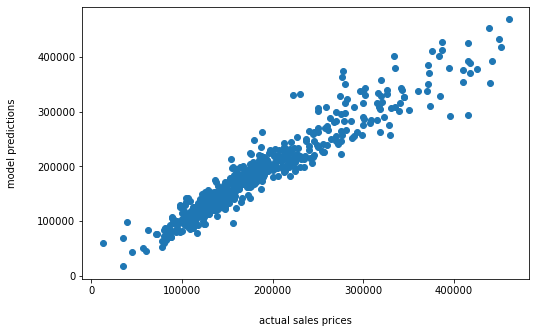

In [24]:
# Linearty Check
plt.figure(figsize=(8,5))

y = y_test
y_preds = lr3.predict(X_test) # our y_test predictions
plt.scatter(y_test, y_preds) # plots our scatters 
plt.xlabel('actual sales prices',labelpad=20)
plt.ylabel('model predictions',labelpad=20)
plt.savefig('../viz/final_pres_images/linearity.png', dpi=180,transparent=False); # high ress=

Ideally what we would want to see in this plot is a straight line, however for the amount of data we have this is generally a strong relationship between our predictions and actual values of a home. We could potentially continue to improve this relationship by including more features. 

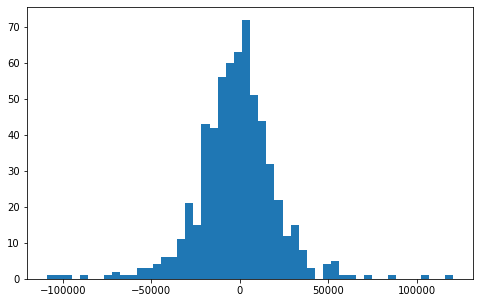

In [25]:
# Checking the normality of the model 
plt.figure(figsize=(8,5))
resids = y - y_preds
plt.hist(resids, bins = 50);
plt.savefig('../viz/final_pres_images/residuals.png', dpi=180,transparent=False); # high ress=

This model appears to generally have a normal distrubution of our residuals, which confirms that our normality of errors holds.

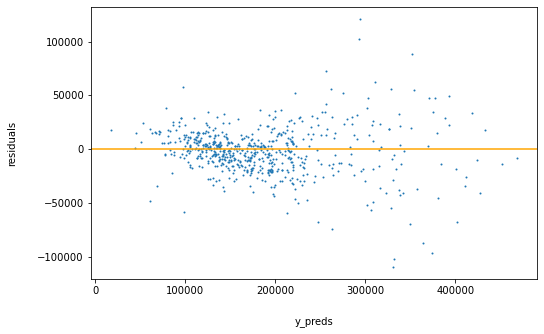

In [107]:

# Equal variance
plt.figure(figsize=(8,5))

plt.scatter(y_preds, resids, s = 1)
plt.axhline(0, color = 'orange')
plt.xlabel('y_preds',labelpad=20)
plt.ylabel('residuals',labelpad=20)
plt.savefig('../viz/final_pres_images/variance.png', dpi=180,transparent=False); # high ress=

This is an important metric to check of our model, from this we can visually see that our errors are closer to 0 within house price ranges that fall below 200,000 USD and as we move further up in prices the model becomes less and less accurate. These variations means that we are over or under predicting the value of a house by the potentially about 50,000 USD or even greater. This is likely occuring because we do not have a significant amount of houses priced in these higher value ranges for our model to learn from.

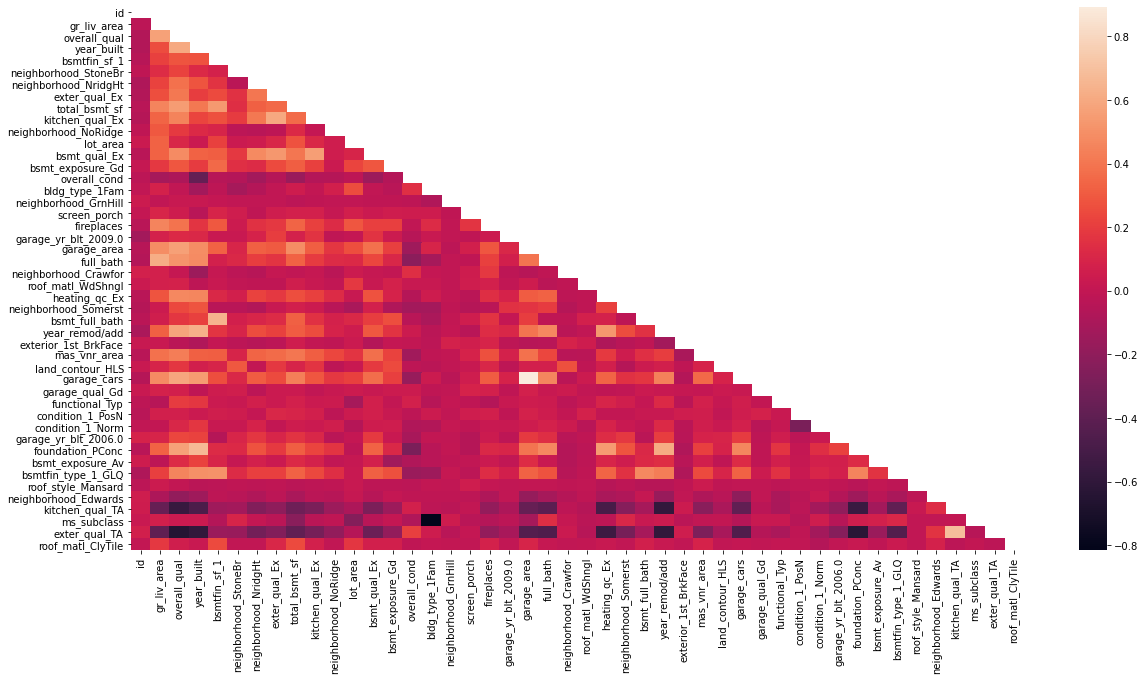

In [26]:
# M/I:
# checking for colinearity

mask = np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (20, 10))
sns.heatmap(
X.corr(),
annot = False,
mask = mask);

From this we can tell that there is some multicollinearity between year remodeled and year built which is not ideal. Additionally there appears to be other highly correlated features, full bath and ground living area or bedrooms above ground and total basment square feet. These are not unexpected but does confirm that the we should not be interpretting anyting quantitative for out coefficients. 

Typically more line checks assumptions could be made but until the last iteration is made, however this does give some guidance that a more predictive model is the path to work towards rather than inferential. 

### Whole data set feature

In [105]:
X = post_lasso_final.drop(columns = ['saleprice']) 
y = post_lasso_final['saleprice']

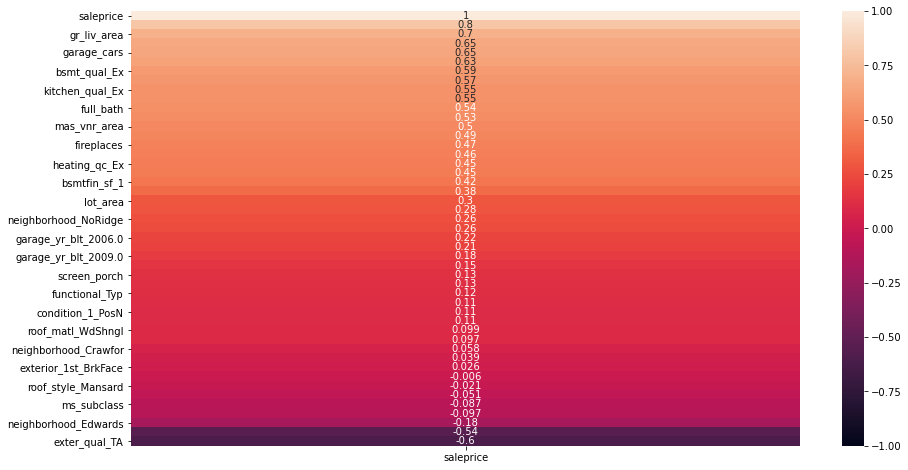

In [106]:

plt.figure(figsize=(15,8))
# plotting correlation of variables of interest
corr = post_lasso_final.corr()[['saleprice']]
sns.heatmap(
    data=corr.sort_values('saleprice',ascending =False),
    vmin=-1, vmax=1, 
    annot=True);

From here we can clearly see that there are a lot of strongly correlated feaures that predict sales price well and more work could be done to drop those features that are notas strongly correlated but that will be left for future work to improve the model. However a quick check will be done to determine if any of these values could potentially be consiered statisically significant based on their p-value, otherwise our coefficients could not be confidently presented as a directly quanititative value but rather as a relationship.

--- 
Quick Stats Summary to check p values:


In [30]:
import statsmodels.api as sm

X = X_train
X = sm.add_constant(X)
y = y_train
mlr = sm.OLS(y, X).fit();

In [31]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     308.6
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:12:01   Log-Likelihood:                -16503.
No. Observations:                1435   AIC:                         3.310e+04
Df Residuals:                    1388   BIC:                         3.335e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.109e+05   1.08e+05     -7.521      0.000   -1.02e+06   -5.99e+05
id                       0.2998      0.802      0.374      0.709      -1.274       1.873
gr_liv_area             39.8259      2.440     16.325      0.000      35.040      44.612
overall_qual          7302.4377    894.732      8.162      0.000    5547.265    9057.610
year_built             306.0007     40.227      7.607      0.000     227.088     384.913
bsmtfin_sf_1            10.8219      2.331      4.643      0.000       6.250      15.394
neighborhood_StoneBr  5.934e+04   5434.948     10.918      0.000    4.87e+04       7e+04
neighborhood_NridgHt  3.756e+04   3764.894      9.977      0.000    3.02e+04    4.49e+04
exter_qual_Ex         3.289e+04   4768.196      6.897      0.000    2.35e+04    4.22e+04
total_bsmt_sf            7.8219      2.420      3.232      0.001       3.075      12.569
kitchen_qual_Ex       2.284e+04   3581.902      6.375      0.000    1.58e+04    2.99e+04
neighborhood_NoRidge  4.268e+04   4690.927      9.098      0.000    3.35e+04    5.19e+04
lot_area                 0.8473      0.160      5.288      0.000       0.533       1.162
bsmt_qual_Ex          1.715e+04   3299.754      5.196      0.000    1.07e+04    2.36e+04
bsmt_exposure_Gd      2.011e+04   2647.576      7.594      0.000    1.49e+04    2.53e+04
overall_cond          5386.8711    743.538      7.245      0.000    3928.292    6845.450
bldg_type_1Fam         1.53e+04   3688.226      4.148      0.000    8065.032    2.25e+04
neighborhood_GrnHill  1.155e+05   1.76e+04      6.570      0.000     8.1e+04     1.5e+05
screen_porch            67.7703     11.604      5.840      0.000      45.008      90.533
fireplaces            6363.7596   1288.822      4.938      0.000    3835.511    8892.008
garage_yr_blt_2009.0  4.723e+04   7141.463      6.614      0.000    3.32e+04    6.12e+04
garage_area              9.2663      7.514      1.233      0.218      -5.474      24.007
full_bath             7700.8831   1815.078      4.243      0.000    4140.291    1.13e+04
neighborhood_Crawfor  1.656e+04   3991.681      4.148      0.000    8726.532    2.44e+04
roof_matl_WdShngl     8.331e+04    1.5e+04      5.536      0.000    5.38e+04    1.13e+05
heating_qc_Ex         5436.5024   1730.399      3.142      0.002    2042.022    8830.982
neighborhood_Somerst  1.461e+04   3017.926      4.842      0.000    8691.792    2.05e+04
bsmt_full_bath        7612.0467   1695.604      4.489      0.000    4285.824    1.09e+04
year_remod/add          80.8495     50.928      1.588      0.113     -19.055     180.754
exterior_1st_BrkFace  1.913e+04   4395.120      4.352      0.000    1.05e+04    2.77e+04
mas_vnr_area            10.8683      4.657      2.334      0.020       1.733      20.004
land_contour_HLS      1.106e+04   3568.373      3.099    

### Stats Summary Reflections ([Reference](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a))
Unfortunately there are not p-values greater than 0.05 which does not allows us to reject the hypothesis that there is no direct relationship between any of our features and our predictors, statisitcally. From this we could potentially interpret our p value for kitchen quality as there being a 37% chance that a typical kitchen quality has no effect on the sale price of a house,  and our results are produced by chance. 

___

# Conclusion and Recommendations

Unfortunately, from this model  cannot determine that there is any statistical significance between the features and salesprice. 
Based on the results of the study the recommendations below to inform future property invesments of what house traits to pay attention when moving forward on Ames, Iowa investments. These conclusions were based on the more feaures with greater absolute value of the final multiple linear regression model (shown below). Additionally this model could be very useful for homeowners that are in the stage of selling their house, it could be utilized as a tool to set  an accurate sale price or inform them of where they want to focus their remoding efforts in. 

Recommendations:
- Location Desirability - houses in houses IN Green Hills, Stone Brook, Northridge,  Northridge Heights avoiding Edwards in particular
- Construction Materials - houses with Wood Shingles rather than Clay or Tile for roof material 
- Condition of the house - houses with Excellent exterior quality and kitchen quality, as well as houses with good garage quality 
- Amenities Proximity    - houses with  average proximity to various (conditions)
- Avoid investing in houses with Brick Face exteriors


In [39]:
final_model.sort_values(ascending=False)[:10]

neighborhood_GrnHill   115,481.71
roof_matl_WdShngl       83,307.27
neighborhood_StoneBr    59,338.44
garage_yr_blt_2009.0    47,231.74
neighborhood_NoRidge    42,680.13
neighborhood_NridgHt    37,560.67
exter_qual_Ex           32,886.08
condition_1_PosN        23,155.71
garage_qual_Gd          23,121.72
kitchen_qual_Ex         22,836.31
dtype: float64


# Future Steps 

More exploration can be conducted tot determine if more tinkering with the final model could create a stronger predicitive model than produced here. Additionally a deeper consideration could be undertaken for the ordinal vs discrete features potentially translating them as categorical to see if the models perfomance would change.